# Classification task
predicting whether something is one thing or another

In [45]:
import torch
import torch.nn as nn
from torchmetrics import F1Score, Accuracy

from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [46]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('File already exist')
else:
    print('File has to be downloaded')
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, \
plot_decision_boundary

File already exist



# Basic architecture of a classification neural network
![ls](img/03-classification-architecture.png)

# 1. Make classification data

In [2]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

print('Shape of X is', X.shape)
print('First 3 points:\n', X[:3])
print('labels:', y[:3])

Shape of X is (1000, 2)
First 3 points:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]]
labels: [1 1 1]


In [3]:
data = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})
data.head(7)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1


In [4]:
data.label.value_counts()

1    500
0    500
Name: label, dtype: int64

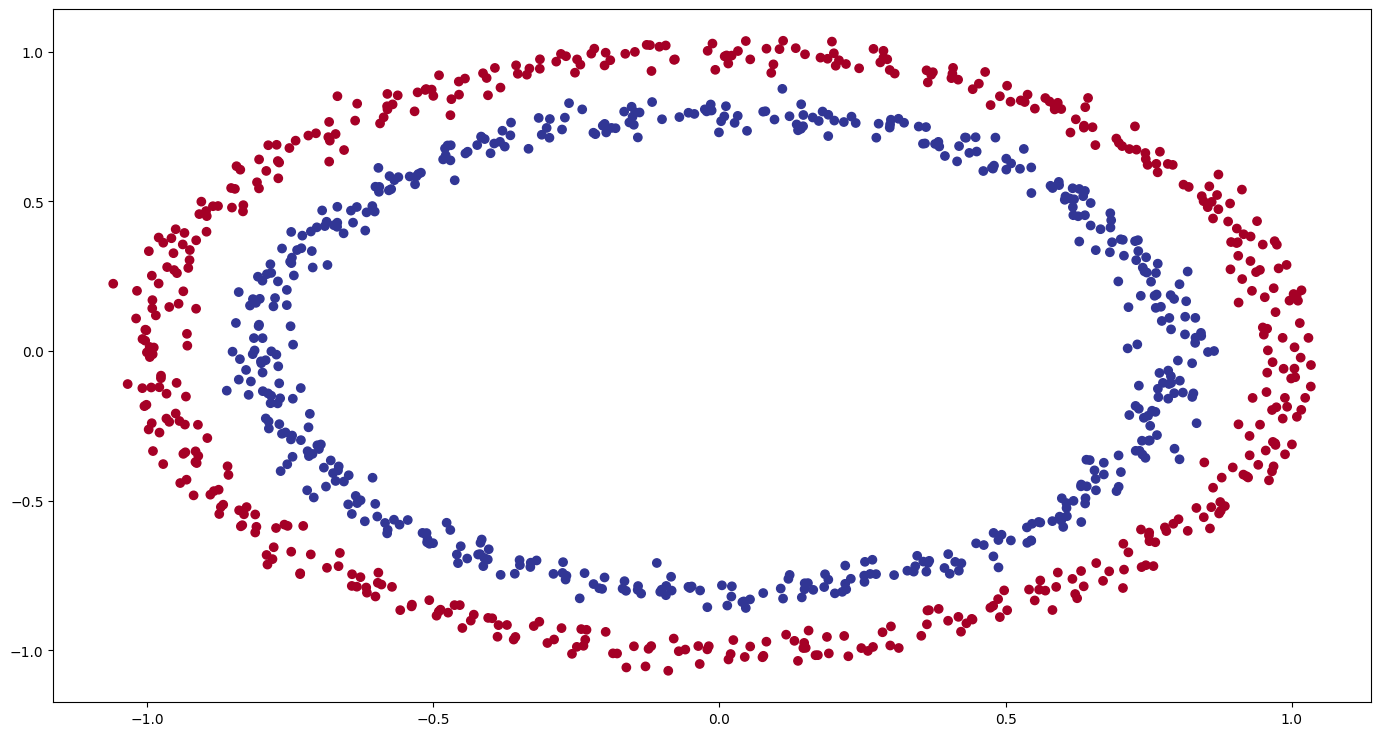

In [5]:
plt.figure(figsize=(17, 9))
plt.scatter(data['X1'], data['X2'], c=data['label'],
            cmap=plt.cm.RdYlBu)

! The most common errors in deep learning is *shape error*. Ask yourself:

"What shapes are my inputs and what shapes are my outputs?"

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
first_features = X[0]
first_label = y[0]
print(f'first point has the features {first_features} and label is {first_label}')
print(f'shape for one sample of features is {first_features.shape} and of label is {first_label.shape}')

first point has the features [0.75424625 0.23148074] and label is 1
shape for one sample of features is (2,) and of label is ()


In [8]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:3]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733]])

In [9]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,                                     random_state=42)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Build a model

In [11]:
# make it agnostic
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [12]:
class CircleBinaryModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(
            in_features=2,
            out_features=5
        )
        self.output_layer = nn.Linear(
            in_features=5,
            out_features=1
        )
        ## the same
        # self.layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    def forward(self, x):
        # return self.layers(x)
        x = self.input_layer(x)
        x = self.output_layer(x)
        return x

In [13]:
model_0 = CircleBinaryModel().to(device)
model_0

CircleBinaryModel(
  (input_layer): Linear(in_features=2, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
)

Our model takes 2 input features `in_features=2` and produces 5 features `out_features=5`. This is known as having 5 **neurons**. The number of neurons you can use in network layers is a **hyperparameter** (you set yourself). It will depend on your model and dataset

**THE RULE**: the next layer has to take the same `in_features` as the previous layer `out_features`

### Why we can not always use nn.Sequential ? (without creating class)
Because `nn.Sequential` allows run things only in sequential order. If you want something else (rather than just straight-forward sequential computation) you should define your own class

In [14]:
X_train = X_train.to(device)
X_test = X_test.to(device)

model_0.eval()
with torch.inference_mode():
    untrained_predictions = model_0(X_test)
# check the shape matching
print(f'Shape of predictions: {untrained_predictions.shape}')
print(f'Shape of original labels: {y_test.shape}')
print(f'First 5 predictions: {untrained_predictions[:5]}')
print(f'First 5 original labels: {y_test[:5]}')

Shape of predictions: torch.Size([200, 1])
Shape of original labels: torch.Size([200])
First 5 predictions: tensor([[0.3757],
        [0.4058],
        [0.3221],
        [0.3908],
        [0.3623]])
First 5 original labels: tensor([1., 0., 1., 0., 1.])


In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

* `BCELoss()` is a **binary cross entropy** criterion between target and predicted labels
* `BCEWithLogitsLoss()` is the same, but it has a sigmoid layer built-in (so we can give raw model outputs, not probabilities)

Also we need the evaluation metrics.

Criterion (loss function) measures how *wrong* our model, but evaluation metric measures how *right* it is

In [24]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

# evaluation metrics
acc = Accuracy(num_classes=2)
f1 = F1Score(num_classes=2)

**logits** can be interpreted as the unnormalised predictions (outputs) of a model. These san give results, but we don't stop with logits, because interpret their raw values is not easy

Each linear layer calls the following: 'y = x*w + b'
and the raw output 'y' is **logit**. These number are hard to interpret, but we can apply non-linear function to make logits as **probabilities** (how much the model thinks the data point belongs to one class or another)

In [17]:
# sigmoid is often used for binary classification problems
# as a activation function

# for multi-class classification problems we use softmax activation
y_pred_probs = torch.sigmoid(untrained_predictions)
y_pred_probs[:3]

tensor([[0.5928],
        [0.6001],
        [0.5798]])

to make prediction labels we only need to round the probabilities

In [18]:
y_pred = torch.round(y_pred_probs).type(torch.int)
y_pred[:3]

tensor([[1],
        [1],
        [1]], dtype=torch.int32)

In [19]:
print(f'Accuracy now is {acc(y_pred.squeeze(), y_test.type(torch.int))}')
print(f'F1Score now is {f1(y_pred.squeeze(), y_test.type(torch.int))}')
print(f'Accuracy now is {accuracy_fn(y_pred.squeeze(), y_test)}')

Accuracy now is 0.5
F1Score now is 0.5
Accuracy now is 50.0


### raw outputs (logits) -> probabilities -> labels

# 3.Train model

In [20]:
torch.manual_seed(42)

epochs = 150
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [21]:
train_loss = []
test_loss = []
accuracy_test = []

for epoch in range(1, epochs+1):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    # apply squeeze to remove extra dimension

    loss = loss_fn(y_logits,
                   y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_labels = torch.round(torch.sigmoid(test_logits))
        current_acc = acc(test_labels.type(torch.int), y_test.type(torch.int))
        accuracy_test.append(current_acc)
        test_loss.append(loss_fn(test_logits, y_test))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}: train loss = {loss.item():.5f}, accuracy test = {current_acc*100:.2f} %')

Epoch 10/150: train loss = 0.70009, accuracy test = 50.00 %
Epoch 20/150: train loss = 0.69585, accuracy test = 50.00 %
Epoch 30/150: train loss = 0.69425, accuracy test = 50.00 %
Epoch 40/150: train loss = 0.69362, accuracy test = 50.00 %
Epoch 50/150: train loss = 0.69335, accuracy test = 53.00 %
Epoch 60/150: train loss = 0.69323, accuracy test = 49.50 %
Epoch 70/150: train loss = 0.69317, accuracy test = 49.50 %
Epoch 80/150: train loss = 0.69313, accuracy test = 50.00 %
Epoch 90/150: train loss = 0.69310, accuracy test = 48.50 %
Epoch 100/150: train loss = 0.69308, accuracy test = 48.00 %
Epoch 110/150: train loss = 0.69307, accuracy test = 48.50 %
Epoch 120/150: train loss = 0.69305, accuracy test = 48.00 %
Epoch 130/150: train loss = 0.69304, accuracy test = 47.00 %
Epoch 140/150: train loss = 0.69303, accuracy test = 47.50 %
Epoch 150/150: train loss = 0.69302, accuracy test = 47.00 %


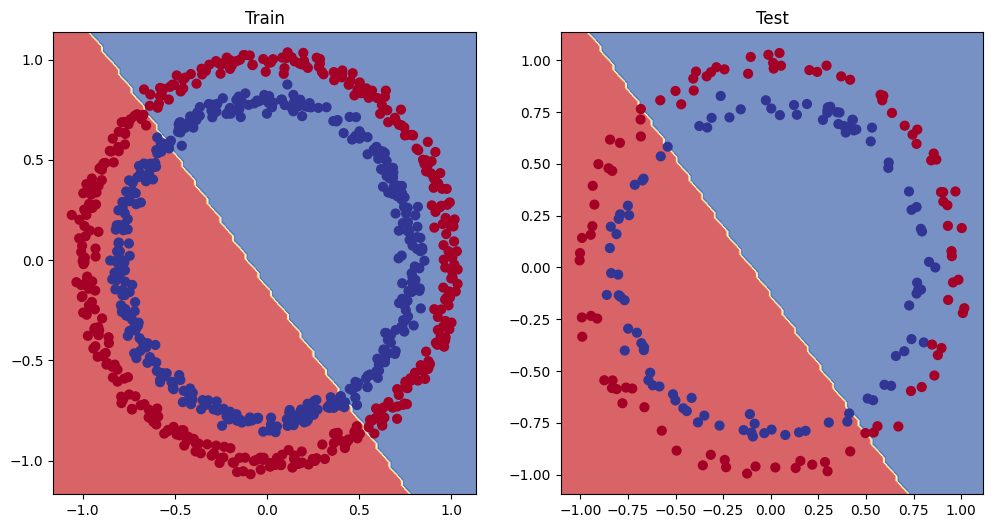

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

As we can see the reason why model perfomance is so bad is that it is trying to split the red and blue points using a straight line. It can explain only 50% accuracy

We should improve our model


..but firstly let see if our model can learn straight linear data

In [74]:
weight = 0.6
bias = 0.3
X_regression = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y_regression = X_regression * weight + bias
print(X_regression.shape, y_regression.shape)

torch.Size([100, 1]) torch.Size([100, 1])


In [75]:
train_split = int(0.8 * len(X_regression))
X_train_regression = X_regression[:train_split]
X_test_regression = X_regression[train_split:]
y_train_regression = y_regression[:train_split]
y_test_regression = y_regression[train_split:]

X_train_regression.shape, y_train_regression.shape, X_test_regression.shape, y_test_regression.shape

(torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([20, 1]))

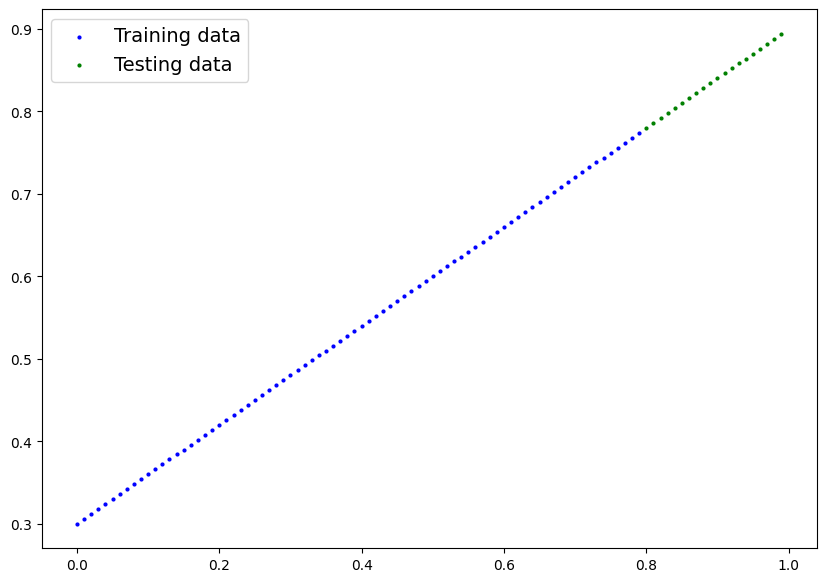

In [76]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [77]:
model_1_regression = nn.Sequential(
    nn.Linear(in_features=1, out_features=5),
    nn.Linear(in_features=5, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_1_regression = model_1_regression.to(device)
model_1_regression

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Linear(in_features=10, out_features=5, bias=True)
  (4): Linear(in_features=5, out_features=1, bias=True)
)

In [78]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_1_regression.parameters(),
                            lr=0.1)

In [79]:
torch.manual_seed(42)

epochs = 150
for epoch in range(1, epochs+1):
    model_1_regression.train()
    # forward
    y_pred = model_1_regression(X_train_regression)
    # loss calc
    loss = loss_fn(y_pred, y_train_regression)
    # zero grad
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # update parameters
    optimizer.step()

    model_1_regression.eval()
    with torch.inference_mode():
        test_preds = model_1_regression(X_test_regression)
        loss_test = loss_fn(test_preds, y_test_regression)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}: loss (train) = {loss.item():.5f} || loss (test) = {loss_test.item():.5f}')

Epoch 10/150: loss (train) = 0.01305 || loss (test) = 0.05962
Epoch 20/150: loss (train) = 0.01188 || loss (test) = 0.05406
Epoch 30/150: loss (train) = 0.01071 || loss (test) = 0.04854
Epoch 40/150: loss (train) = 0.00954 || loss (test) = 0.04308
Epoch 50/150: loss (train) = 0.00840 || loss (test) = 0.03772
Epoch 60/150: loss (train) = 0.00727 || loss (test) = 0.03251
Epoch 70/150: loss (train) = 0.00619 || loss (test) = 0.02753
Epoch 80/150: loss (train) = 0.00517 || loss (test) = 0.02287
Epoch 90/150: loss (train) = 0.00423 || loss (test) = 0.01861
Epoch 100/150: loss (train) = 0.00338 || loss (test) = 0.01480
Epoch 110/150: loss (train) = 0.00264 || loss (test) = 0.01151
Epoch 120/150: loss (train) = 0.00202 || loss (test) = 0.00874
Epoch 130/150: loss (train) = 0.00150 || loss (test) = 0.00648
Epoch 140/150: loss (train) = 0.00110 || loss (test) = 0.00470
Epoch 150/150: loss (train) = 0.00078 || loss (test) = 0.00334


In [80]:
model_1_regression.eval()
with torch.inference_mode():
    predictions = model_1_regression(X_test_regression)

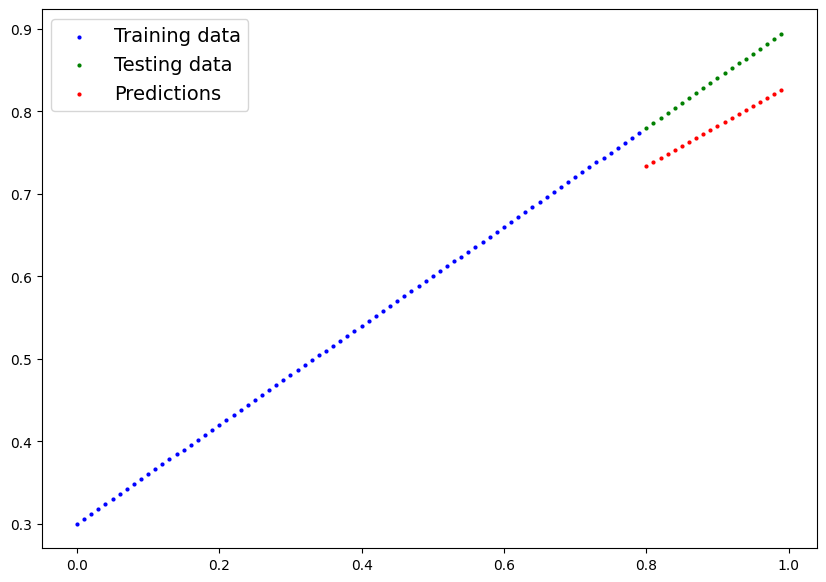

In [81]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=predictions)

It looks like our model is able to do far better than random guessing on straight lines


> **Helpful hint**: troubleshooting step is to start as small as possible (simple network and simple dataset) to see if the model works before scaling it up.

# 4. Improve model (work with model, not the data)
![img2](img/ch3-model-improvement.png)


> Note: because you can adjust all of these by hand, they're referred to as hyperparameters.

And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

In [86]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,
                                out_features=10)
        self.layer2 = nn.Sequential(
                                nn.Linear(in_features=10,
                                            out_features=5),
                                nn.Softplus())
        self.layer3 = nn.Linear(in_features=5,
                                out_features=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.layer3(x)

In [87]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer3): Linear(in_features=5, out_features=1, bias=True)
)

In [88]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

In [89]:
torch.manual_seed(42)
loss_train_array = []
loss_test_array = []
accuracy_test = []

epochs = 2500
for epoch in range(1, epochs+1):
    model_1.train()
    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_labels = torch.round(torch.sigmoid(y_logits))

    # loss calc
    loss = loss_fn(y_logits, y_train)

    # zero grad
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    # additionally
    loss_train_array.append(loss.item())

    # evaluation
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        loss_test = loss_fn(test_logits, y_test)
        test_labels = torch.round(torch.sigmoid(test_logits))
        loss_test_array.append(loss_test.item())
        accuracy = accuracy_fn(test_labels, y_test)
        accuracy_test.append(accuracy)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}: loss (train) = {loss.item()} || loss (test) = {loss_test.item()} || accuracy (test) is {accuracy}%')

Epoch 100/2500: loss (train) = 0.6927856206893921 || loss (test) = 0.6945111155509949 || accuracy (test) is 47.0%
Epoch 200/2500: loss (train) = 0.6913657188415527 || loss (test) = 0.6944143772125244 || accuracy (test) is 47.5%
Epoch 300/2500: loss (train) = 0.6752371191978455 || loss (test) = 0.6841471791267395 || accuracy (test) is 53.0%
Epoch 400/2500: loss (train) = 0.6542800068855286 || loss (test) = 0.6794370412826538 || accuracy (test) is 52.0%
Epoch 500/2500: loss (train) = 0.648120105266571 || loss (test) = 0.6736341714859009 || accuracy (test) is 54.0%
Epoch 600/2500: loss (train) = 0.5900120735168457 || loss (test) = 0.6136743426322937 || accuracy (test) is 70.0%
Epoch 700/2500: loss (train) = 0.4423617422580719 || loss (test) = 0.4873940944671631 || accuracy (test) is 88.0%
Epoch 800/2500: loss (train) = 0.3028779923915863 || loss (test) = 0.3561742305755615 || accuracy (test) is 94.5%
Epoch 900/2500: loss (train) = 0.2057783156633377 || loss (test) = 0.2560400068759918 || 

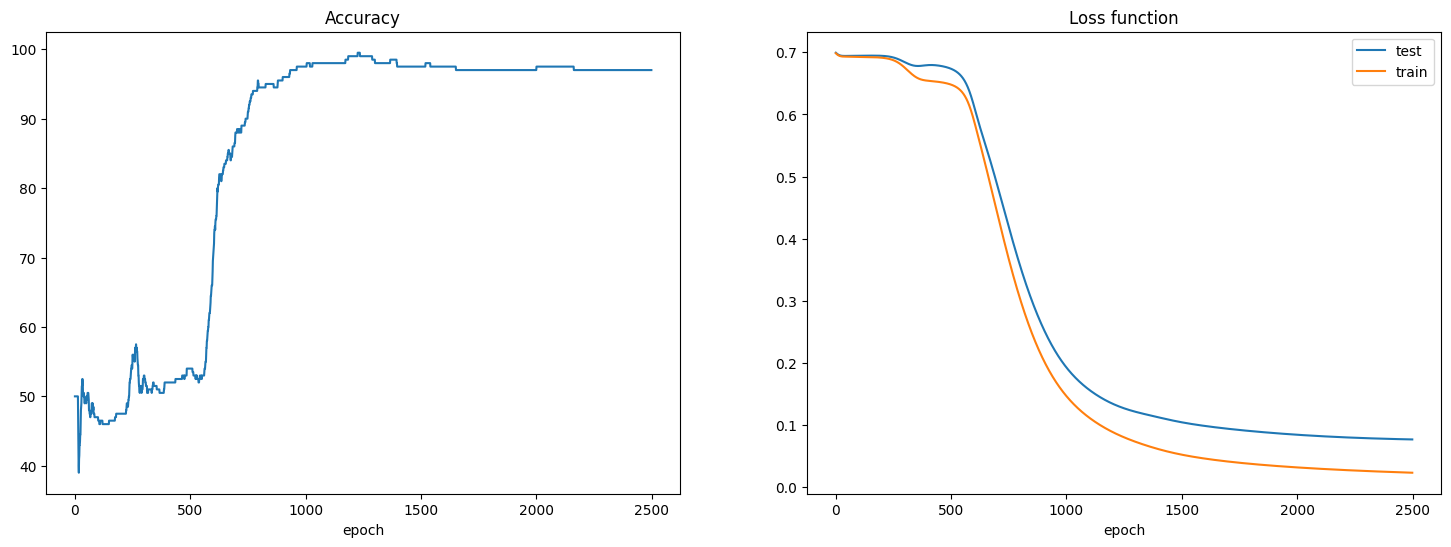

In [90]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(accuracy_test)
plt.title('Accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(loss_test_array, label='test')
plt.plot(loss_train_array, label='train')
plt.legend()
plt.title('Loss function')
plt.xlabel('epoch')

plt.show()

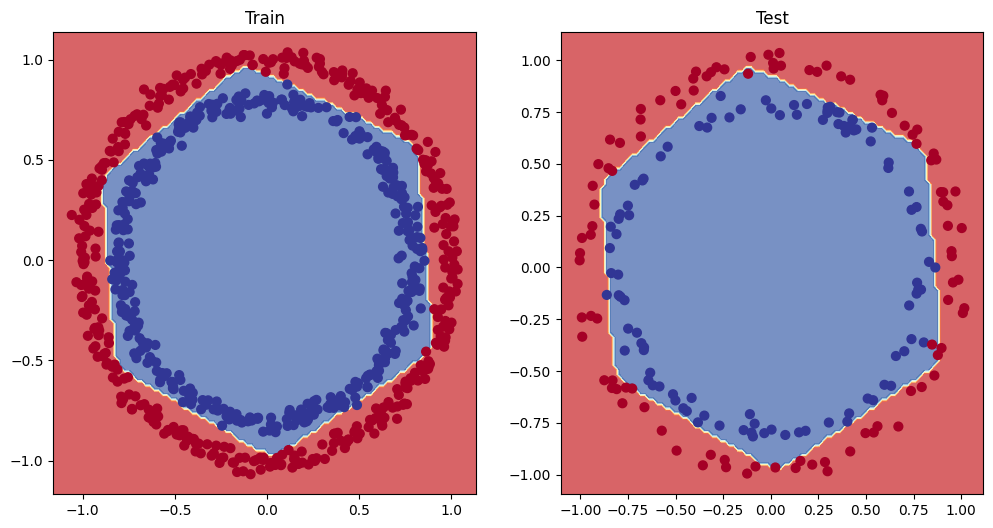

In [91]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

We saw how adding non-linear activation functions to our model can helped it to learn. Much of the data we will encounter is non-linear

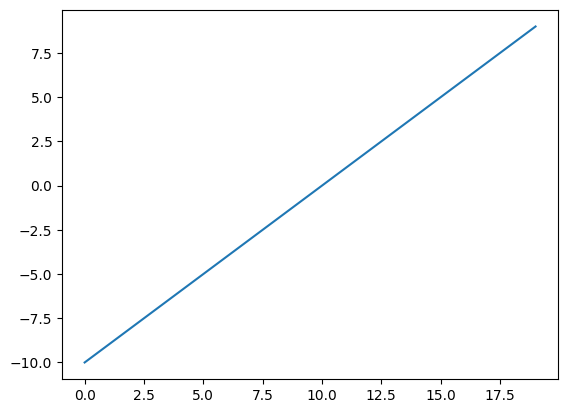

In [92]:
# replication non-linear functions
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

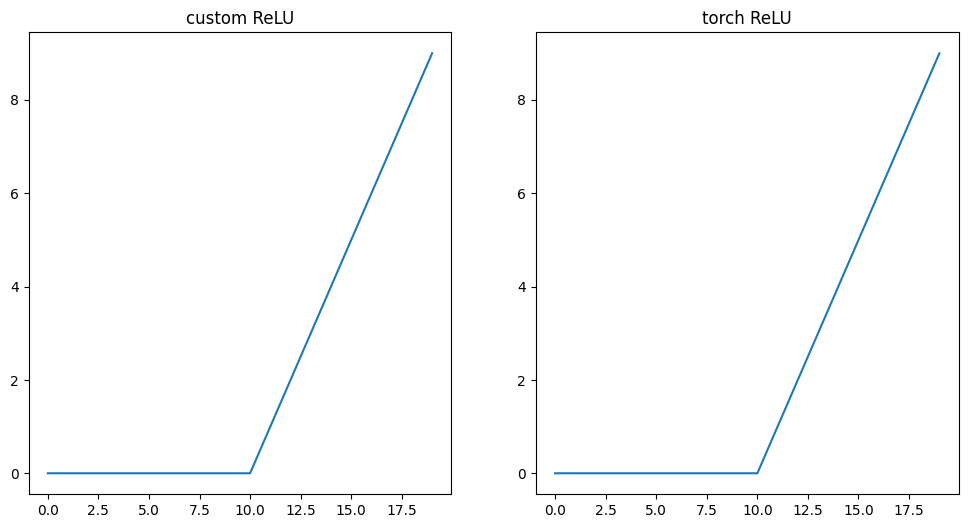

In [99]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)
torch_relu = nn.ReLU()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('custom ReLU')
plt.plot(relu(A))

plt.subplot(1, 2, 2)
plt.title('torch ReLU')
plt.plot(torch_relu(A))

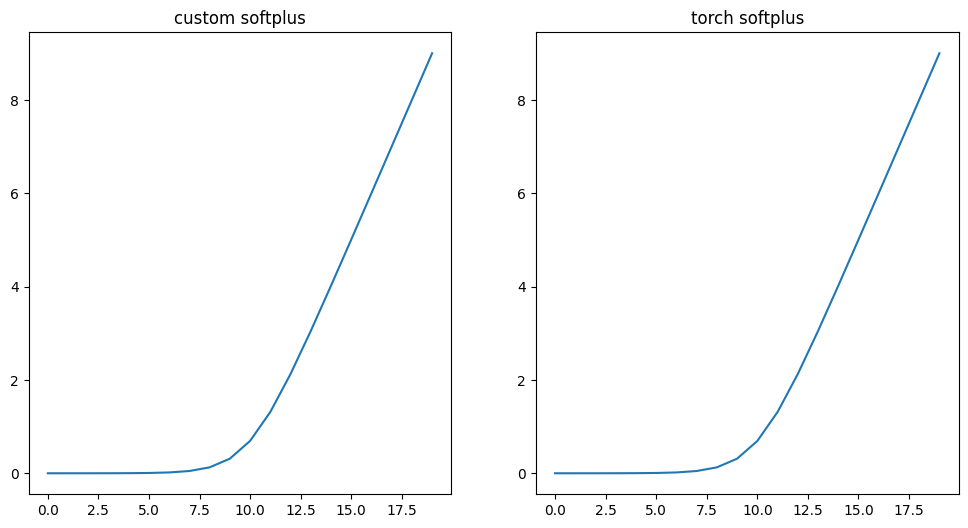

In [100]:
def softplus(x, beta=1):
    return (1/beta) * torch.log(1+torch.exp(beta*x))

torch_softplus = nn.Softplus()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('custom softplus')
plt.plot(softplus(A))

plt.subplot(1, 2, 2)
plt.title('torch softplus')
plt.plot(torch_softplus(A))

We can draw almost anything when use an unlimited amount of linear and non-linear lines

# 5. Putting all together: multi-class problem


## 5.1 Data creating

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
X_blob.shape, y_blob.shape

((1000, 2), (1000,))

In [3]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
X_blob[:3], y_blob[:3]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661]]),
 tensor([3, 2, 2]))

In [20]:
# classes distributions
unique, counts = np.unique(y_blob, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 250]
 [  1 250]
 [  2 250]
 [  3 250]]


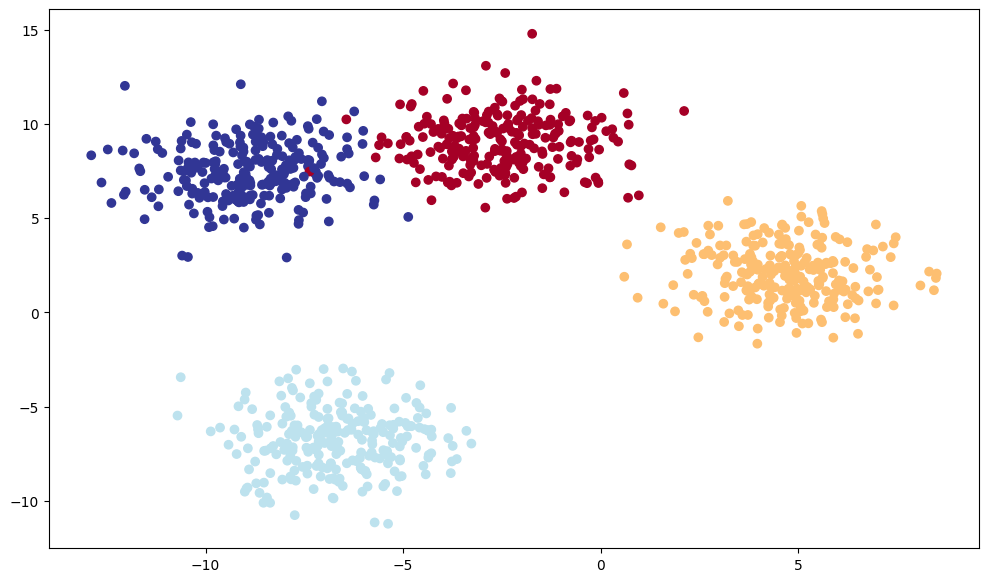

In [4]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(12, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

## 5.2 Build model

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [6]:
class BlobModel(nn.Module):
    def __init__(self, input, output, hidden_units=8):
        super().__init__()
        self.linear_layers_stack = nn.Sequential(
            nn.Linear(in_features=input,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units*2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*2,
                      out_features=hidden_units),
            nn.Softplus(),
            nn.Linear(in_features=hidden_units,
                      out_features=output),
        )
    def forward(self, x):
        return self.linear_layers_stack(x)

In [26]:
model_4 = BlobModel(input=NUM_FEATURES,
                    output=NUM_CLASSES).to(device)
model_4

BlobModel(
  (linear_layers_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Softplus(beta=1, threshold=20)
    (5): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.01)

In [28]:
example_preds = model_4(X_blob_train[:3])
example_preds

tensor([[ 0.4800,  0.5725, -0.7012, -0.1474],
        [ 0.2909,  0.4415, -0.7711, -0.3366],
        [ 0.4276,  0.8380, -0.9921, -0.6981]], grad_fn=<AddmmBackward0>)

As we remember: `logits` -> `probabilites` -> `labels`. In binary classification we use *sigmoid* for proba and *round* for labels. Now we have raw output for each class. We use *softmax* activation for proba (
these prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class) and *argmax* for labels

In [29]:
example_proba = torch.softmax(example_preds, dim=1)
example_proba

tensor([[0.3404, 0.3734, 0.1045, 0.1818],
        [0.3287, 0.3821, 0.1137, 0.1755],
        [0.3254, 0.4904, 0.0787, 0.1056]], grad_fn=<SoftmaxBackward0>)

In [30]:
# sum of each row equal to 1, because it is probabilities
torch.sum(example_proba, dim=1)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [31]:
# labels
torch.argmax(example_proba, dim=1)

tensor([1, 1, 1])

## 5.3 Training loop

In [33]:
torch.manual_seed(42)
epochs = 250

In [34]:
loss_test_array, loss_train_array, accuracy_array = [], [], []
for epoch in range(1, epochs+1):
    model_4.train()
    y_logits = model_4(X_blob_train).squeeze()
    y_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train_array.append(loss.item())
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test).squeeze()
        test_labels = torch.softmax(test_logits, dim=1).argmax(dim=1)
        loss_test = loss_fn(test_logits, y_blob_test)
        accuracy_test = accuracy_fn(test_labels, y_blob_test)

        loss_test_array.append(loss_test.item())
        accuracy_array.append(accuracy_test)

    if epoch % 25 == 0:
        print('Epoch {}/{}:'.format(epoch, epochs))
        print('loss (train) = {} || loss (test) = {} || accuracy = {}'.format(loss.item(), loss_test.item(), accuracy_test))

Epoch 25/250:
loss (train) = 1.3479632139205933 || loss (test) = 1.3883668184280396 || accuracy = 42.5
Epoch 50/250:
loss (train) = 1.202305555343628 || loss (test) = 1.2382155656814575 || accuracy = 44.5
Epoch 75/250:
loss (train) = 1.0599315166473389 || loss (test) = 1.0911020040512085 || accuracy = 44.5
Epoch 100/250:
loss (train) = 0.9111306667327881 || loss (test) = 0.9334184527397156 || accuracy = 52.0
Epoch 125/250:
loss (train) = 0.7455049753189087 || loss (test) = 0.757007360458374 || accuracy = 95.0
Epoch 150/250:
loss (train) = 0.5523902773857117 || loss (test) = 0.5551148653030396 || accuracy = 99.0
Epoch 175/250:
loss (train) = 0.3549514710903168 || loss (test) = 0.35305920243263245 || accuracy = 99.5
Epoch 200/250:
loss (train) = 0.23266929388046265 || loss (test) = 0.23023559153079987 || accuracy = 99.5
Epoch 225/250:
loss (train) = 0.16634723544120789 || loss (test) = 0.16304706037044525 || accuracy = 99.5
Epoch 250/250:
loss (train) = 0.12641561031341553 || loss (test)

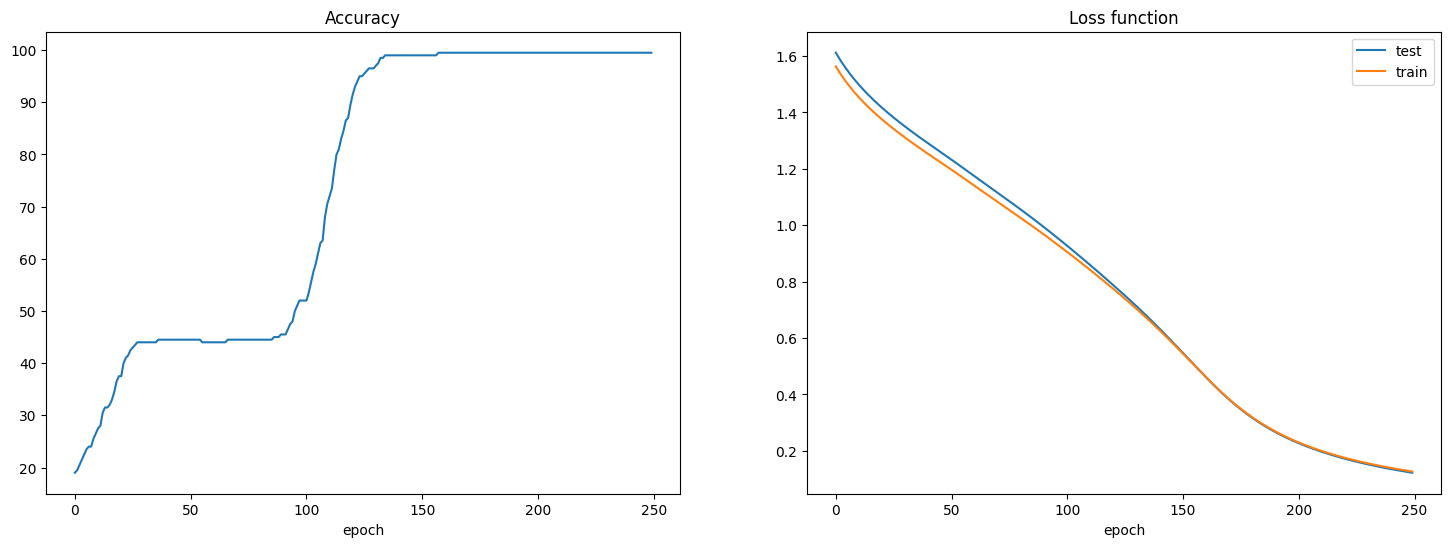

In [35]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(accuracy_array)
plt.title('Accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(loss_test_array, label='test')
plt.plot(loss_train_array, label='train')
plt.legend()
plt.title('Loss function')
plt.xlabel('epoch')

plt.show()

## 5.4 Make prediction and visualize it

In [40]:
model_4.eval()
with torch.inference_mode():
    prediction_logits = model_4(X_blob_test)
    prediction_proba = torch.softmax(prediction_logits, dim=1)
    prediction_labels = prediction_proba.argmax(dim=1)

print('Logits -> \n',prediction_logits[:3])
print('Probabilities -> \n', prediction_proba[:3])
print('Labels -> \n',prediction_labels[:3])

Logits -> 
 tensor([[ 0.6870,  3.6455, -2.3033, -2.2399],
        [-0.6567, -3.9130, -2.8094,  1.3549],
        [-2.3081, -1.4650,  3.5377, -0.4752]])
Probabilities -> 
 tensor([[0.0491, 0.9458, 0.0025, 0.0026],
        [0.1159, 0.0045, 0.0135, 0.8662],
        [0.0028, 0.0065, 0.9731, 0.0176]])
Labels -> 
 tensor([1, 3, 2])


We can skip `torch.softmax()` step and go straight from logits to labels by calling `torch.argmax()`

In [42]:
prediction_logits[:3].argmax(dim=1)

tensor([1, 3, 2])

#### ! If we want to visualuze our data we should move it on the GPU (matplotlib require it) !

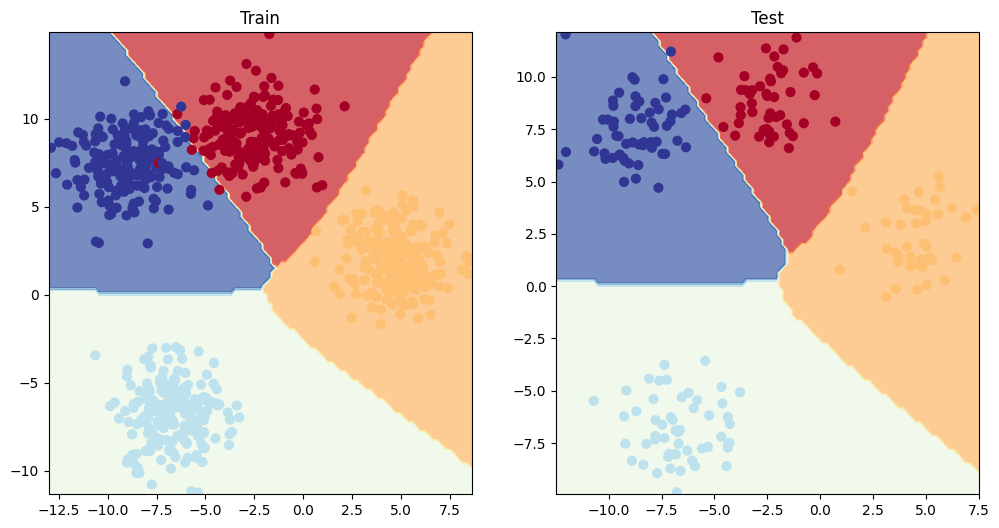

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model=model_4,
                       X=X_blob_train,
                       y=y_blob_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model=model_4,
                       X=X_blob_test,
                       y=y_blob_test)

## 5.5 Model evaluation
Scikit-learn has many different metrics and if you are looking for PyTorch version of it, you should use **Torchmetrics**

In [48]:
from torchmetrics import Accuracy, F1Score, CohenKappa

acc = Accuracy(num_classes=NUM_CLASSES).to(device)
f1 = F1Score(num_classes=NUM_CLASSES).to(device)
cohen = CohenKappa(num_classes=NUM_CLASSES).to(device)

In [53]:
print(f'accuracy: {acc(y_blob_test, prediction_labels).item():.5f}')
print(f'f1-score: {f1(y_blob_test, prediction_labels).item():.4f}')
print(f'Cohen Kappa: {cohen(y_blob_test, prediction_labels).item():.4f}')

accuracy: 0.99500
f1-score: 0.9950
Cohen Kappa: 0.9933
